In [1]:
import numpy as np

# 导入math库，主要使用其一些函数，比如取整函数、指数函数
import math

# 导入scipy.io库，主要用于读取matlab的mat文件
import scipy.io as scio

# 导入sns库，用于绘制热力图
import seaborn as sns

# 导入colors库，用于热力图的细节设置
import matplotlib.colors as mcolors

# 导入matplotlib.pyplot函数，用于绘制图片
import matplotlib.pyplot as plt

# 导入Image函数，用于旋转图片
from PIL import Image,ImageOps

# 导入train_test_split函数，用于分割训练集和测试集
from sklearn.model_selection import train_test_split

# 导入LabelBinarizer类，对y快速进行one-hot编码
from sklearn.preprocessing import LabelBinarizer

# 导入sklearn库的load_digits函数，用于加载手写数字数据集
from sklearn.datasets import load_digits as sklearn_load_digits

# 利用sklearn库加载MNIST数据集
from sklearn.datasets import fetch_openml

# 利用skimage库将MNIST数据集的图片大小缩放
from skimage.transform import resize

from skimage.filters import threshold_otsu

# 导入concatenate_sequences函数，用于将图片和分类转为特定的ndarray数组
from pyrcn.util import concatenate_sequences

# 导入pyrcn的增量回归器
from pyrcn.linear_model import IncrementalRegression

# 导入pyrcn.metrics的函数，用于计算分类后的混淆矩阵，准确度，精确度，召回率和f1得分
from pyrcn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

# 导入cast函数，用于保证类型为ndarray
from typing import cast

# pickle库用于保存随机矩阵，便于下次使用
import pickle

In [2]:
# 文件相对路径
mnist_dir = "./MNIST_dataset/"
save_mnist_dir = "./save_MNIST_image/"
mydata_dir = "./My_custom_dataset/"
save_custom_dir = "./save_custom_image/"

In [3]:
# 图像修剪和填充，用于将保存有效部分，删除多余部分，并使图片变为方阵
def image_crop_pad(arr,pad_size):
    # 先删去全0行/列
    zero_rows = np.all( arr == 0, axis=1)
    zero_cols = np.all( arr == 0, axis=0)
    arr = arr[~zero_rows][:, ~zero_cols]
    # 填充全0行/列至图片为方阵
    max_size = max(arr.shape)
    rows_to_add = max_size - arr.shape[0]
    cols_to_add = max_size - arr.shape[1]
    # 确定原始数组应该放置的位置
    top_rows = rows_to_add // 2
    bottom_rows = rows_to_add - top_rows
    left_cols = cols_to_add // 2
    right_cols = cols_to_add - left_cols
    # 使用 numpy.pad() 在中心放置原始数组，并在周围添加全0行和全0列
    padded_arr = np.pad(arr, ((top_rows, bottom_rows), (left_cols, right_cols)), mode='constant')
    padded_arr = np.pad(padded_arr, ((pad_size, pad_size), (pad_size, pad_size)), mode='constant', constant_values=0)
    # 返回方阵
    return padded_arr

In [4]:
# 获取部分MNIST图像数据和标签函数
def get_MNIST_resized_dataset(MNIST, need_image_num = 1000, re_size = 14, cache_load = False):
    '''
    MNIST:MNIST数据集
    need_image_num:要加载的图片总数量,默认1000张
    re_size:图片预处理后的大小,默认14*14
    cache_load:是否使用已保存的文件,默认False
    '''
    if cache_load:
        # 使用已保存的MNIST处理图像数据和标签
        X_resized_MNIST = np.load("./X_resized_MNIST.npy",allow_pickle=True)
        y_resized_MNIST = np.load("./y_resized_MNIST.npy",allow_pickle=True)
    
    else:    
        # 加载对应数量的数据集
        X_MNIST, y_MNIST = MNIST['data'][:need_image_num], MNIST['target'][:need_image_num]

        # 所获图像整理为对应大小并二值化
        # 自动确定二值化阈值
        # 获得大小转变后的输入数据集
        X_resized_MNIST = np.empty(shape = (X_MNIST.shape[0]), dtype = object)
        for i in range(X_MNIST.shape[0]):
            # reshape即可将图片转为正常的二维矩阵
            image = X_MNIST[i].reshape(28, 28)
            # 图像裁剪
            image = image_crop_pad(image,pad_size=2)
            X_resized_MNIST[i] = image.astype(np.uint8)
            # 修改图片大小
            resized_image = resize(image, (re_size, re_size), order=2, mode='reflect', preserve_range=True, anti_aliasing=False)
            X_resized_MNIST[i] = resized_image.astype(np.uint8)
            threshold_value = threshold_otsu(X_resized_MNIST[i])
            X_resized_MNIST[i] = np.where(X_resized_MNIST[i] <= threshold_value, 0, 1)
            X_resized_MNIST[i] = np.flip(np.rot90(X_resized_MNIST[i],k=1),0)
            X_resized_MNIST[i] = np.array(X_resized_MNIST[i])

        # 处理y_MNIST格式，提取目标值
        y_resized_MNIST = np.empty(shape = (y_MNIST.shape[0]), dtype = object)
        for k, _ in enumerate(y_MNIST):
            y_resized_MNIST[k] = np.array([int(y_MNIST[k][0])])

    # 将所得预处理后的图片分割为训练集和测试集
    stratify = np.asarray([np.unique(yt) for yt in y_resized_MNIST]).flatten()
    X_resize_MNIST_train, X_resize_MNIST_test, y_resize_MNIST_train, y_resize_MNIST_test = train_test_split(
        X_resized_MNIST, y_resized_MNIST, test_size=0.2, stratify=stratify, random_state=42)
    X_MNIST_tr = np.copy(X_resize_MNIST_train)
    y_MNIST_tr = np.copy(y_resize_MNIST_train)
    X_MNIST_te = np.copy(X_resize_MNIST_test)
    y_MNIST_te = np.copy(y_resize_MNIST_test)

    # 训练集目标需要重复re_size次以逐行匹配值
    for k, _ in enumerate(y_MNIST_tr):
        y_MNIST_tr[k] = np.repeat(y_MNIST_tr[k], re_size, 0)
    
    # 展示部分结果
    # pos = 66
    # num = 10
    # for i in range(num):
        # plt.figure(figsize=(2,2))
        # plt.subplot(1,2,1)
        # plt.imshow(X_resized_MNIST[i+pos], cmap='gray')
        # plt.title(y_MNIST[i+pos])
        # plt.axis('off')

        # plt.subplot(1, 2, 2)
        # plt.imshow(X_MNIST[i+pos].reshape(28, 28), cmap='gray')
        # plt.title(y_MNIST[i+pos])
        # plt.axis('off')
    # plt.show()

    np.save("./X_resized_MNIST.npy",X_resized_MNIST)
    np.save("./y_resized_MNIST.npy",y_resized_MNIST)
    
    # 返回结果
    return X_MNIST_tr,y_MNIST_tr,X_MNIST_te,y_MNIST_te

In [5]:
# 获取自定义图像数据和标签函数
def get_Custom_resized_image(re_size = 14,cache_load = False):
    '''
    cache_load:是否使用已保存的文件,默认False
    '''
    
    # 自定义的图像缩放时间较长，所以选择保存最后结果再加载以提高速度
    if cache_load:
        
        # 分别加载保存在文件中的手写板和电子手写版本的自定义手写图像数据和标签
        X_resized_Custom_image = np.load('./X_resized_Custom_image.npy',allow_pickle=True)
        y_Custom_image = np.load('./y_Custom_image.npy',allow_pickle=True)

        X_resized_Custom_image2 = np.load('./X_resized_Custom_image2.npy',allow_pickle=True)
        y_Custom_image2 = np.load('./y_Custom_image2.npy',allow_pickle=True)
        
        # 合并两个版本的数据集
        X_resized_Custom_image = np.concatenate( (X_resized_Custom_image,X_resized_Custom_image2) ) 
        y_Custom_image = np.concatenate( (y_Custom_image,y_Custom_image2) ) 
    
    else:
        # 获取自定义手写图像数据和标签(手写版)
        X_Custom_image = np.empty(shape = (20), dtype = object)
        y_Custom_image = np.empty(shape = (20), dtype = object)
        for k, _ in enumerate(y_Custom_image):
            y_Custom_image[k] = np.array([int(k%10)])
        # 打开相应的JPG图像并完成np.array的转化
        for i in range(10):
            image = Image.open(mydata_dir+str(i)+"_1.jpg")
            image = ImageOps.exif_transpose(image)
            gray_image = image.convert('L')
            # 将图像转换为NumPy数组
            img_array = np.array(gray_image)
            # 保存图像
            X_Custom_image[i] = img_array
            image = Image.open(mydata_dir+str(i)+"_2.jpg")
            image = ImageOps.exif_transpose(image)
            gray_image = image.convert('L')
            img_array = np.array(gray_image)
            X_Custom_image[i+10] = img_array

        # # 展示原始灰度化后图片
        # for i in range(X_Custom_image.shape[0]):
        #     plt.figure(figsize=(4,4))
        #     plt.subplot(1,2,1)
        #     plt.imshow(X_Custom_image[i], cmap='gray')
        #     plt.title(y_Custom_image[i][0])
        #     plt.axis('off')

        # 修改图片大小
        X_resized_Custom_image = np.copy(X_Custom_image)
        for i in range(X_resized_Custom_image.shape[0]):
            threshold_value = threshold_otsu(X_resized_Custom_image[i])    
            # 由于实际的字为白纸黑字，需要将黑白反向映射
            X_resized_Custom_image[i] = np.where(X_resized_Custom_image[i] <= threshold_value, 1, 0)
            X_resized_Custom_image[i] = image_crop_pad(X_resized_Custom_image[i],200)
            X_resized_Custom_image[i] = resize(X_resized_Custom_image[i], (re_size, re_size), order=2, mode='reflect', preserve_range=True, anti_aliasing=True)
            # # 由于有高斯滤波抗锯齿，需要第二次二值化
            threshold_value = threshold_otsu(X_resized_Custom_image[i])
            X_resized_Custom_image[i] = np.where(X_resized_Custom_image[i] <= threshold_value, 0, 1)
            X_resized_Custom_image[i] = np.flip(np.rot90(X_resized_Custom_image[i],k=1),0)
            X_resized_Custom_image[i] = np.array(X_resized_Custom_image[i])

        # # 展示处理后图片
        # for i in range(X_resized_Custom_image.shape[0]):
        #     plt.figure(figsize=(4,4))
        #     plt.subplot(1,2,1)
        #     plt.imshow(X_resized_Custom_image[i], cmap='gray')
        #     plt.title(y_Custom_image[i][0])
        #     plt.axis('off')
        
        # # # 保存处理结果
        # # np.save('./X_resized_Custom_image.npy', X_resized_Custom_image)
        # # np.save('./y_Custom_image.npy', y_Custom_image)
        
        # 获取自定义手写图像数据和标签（电子手写版本）
        X_Custom_image2 = np.empty(shape = (20), dtype = object)
        y_Custom_image2 = np.empty(shape = (20), dtype = object)
        for k, _ in enumerate(y_Custom_image2):
            y_Custom_image2[k] = np.array([int(k%10)])

        # 打开相应的png图像并完成np.array的转化
        for i in range(10):
            image = Image.open(mydata_dir+str(i)+"_3.png")
            image = ImageOps.exif_transpose(image)
            gray_image = image.convert('L')
            # 将图像转换为NumPy数组
            img_array = np.array(gray_image)
            # 保存图像
            X_Custom_image2[i] = img_array
            image = Image.open(mydata_dir+str(i)+"_4.png")
            image = ImageOps.exif_transpose(image)
            gray_image = image.convert('L')
            img_array = np.array(gray_image)
            X_Custom_image2[i+10] = img_array
            
        # 修改图片大小
        X_resized_Custom_image2 = np.copy(X_Custom_image2)
        for i in range(X_resized_Custom_image2.shape[0]):
            threshold_value = threshold_otsu(X_resized_Custom_image2[i])    
            # 由于实际的字为白纸黑字，需要将黑白反向映射
            X_resized_Custom_image2[i] = np.where(X_resized_Custom_image2[i] <= threshold_value, 1, 0)
            X_resized_Custom_image2[i] = image_crop_pad(X_resized_Custom_image2[i],100)
            X_resized_Custom_image2[i] = resize(X_resized_Custom_image2[i], (re_size, re_size), order=2, mode='reflect', preserve_range=True, anti_aliasing=True)
            # # 由于有高斯滤波抗锯齿，需要第二次二值化
            threshold_value = threshold_otsu(X_resized_Custom_image2[i])
            X_resized_Custom_image2[i] = np.where(X_resized_Custom_image2[i] <= threshold_value, 0, 1)
            X_resized_Custom_image2[i] = np.flip(np.rot90(X_resized_Custom_image2[i],k=1),0)
            X_resized_Custom_image2[i] = np.array(X_resized_Custom_image2[i])
        
        # # 展示处理后图片
        # for i in range(X_resized_Custom_image2.shape[0]):
        #     plt.figure(figsize=(4,4))
        #     plt.subplot(1,2,1)
        #     plt.imshow(X_resized_Custom_image2[i], cmap='gray')
        #     plt.title(y_Custom_image2[i][0])
        #     plt.axis('off')

        # # 保存处理结果
        np.save('./X_resized_Custom_image2.npy', X_resized_Custom_image2)
        np.save('./y_Custom_image2.npy', y_Custom_image2)
        
        # 合并两个版本的数据集
        X_resized_Custom_image = np.concatenate( (X_resized_Custom_image,X_resized_Custom_image2) ) 
        y_Custom_image = np.concatenate( (y_Custom_image,y_Custom_image2) ) 
        
    return X_resized_Custom_image, y_Custom_image

In [6]:
# 定义image_to_signal类，用于将图片转为时域信号进行预测
class image_to_signal:
    # 初始化函数
    def __init__(self,
                X_signal : np.array = None,
                Y_result : np.array = None,
                N_res : int = 50,
                K_in : int = -1,
                pulse_time : float = 1,
                time_frame : float = 3,
                interval_time : float = 2, 
                sparsity : float = -1,
                random_sequence: np.array = None):
        '''
        X_signal: 输入的图片，经过了二级化处理，可以根据像素确定是否有信号
        Y_result: 图片的分类结果，已进行了预处理后的图片，用于训练的拟合
        N_res: 隐藏层神经元数量，对应忆阻器的数量
        K_in: 稀疏性，对应的是每个忆阻器读取的每行图片元素数量
        pulse_time: 脉冲时间长度，对应的是单个信号的激活时间
        time_frame: 时间帧长度，对应的是单个信号的激活和衰减时间
        interval_time: 时间步间隔长度，对应的是每个
        sparsity: 稀疏性，对应的是每个忆阻器读取的每行图片元素数量比例
        random_sequence: 随机序列矩阵，从外面获得，使得不同类可共享
        '''
        # 根据mat文件设置激活信号的值计算和衰减值的计算
        self.up = scio.loadmat('../up.mat')["p"][0]
        self.down = scio.loadmat('../down.mat')["p2"][0]
        
        # 记录忆阻器数量
        self.N_res = N_res
        
        # 记录脉冲时间长度，时间帧长度和时间步的间隔长度
        self.pulse_time = pulse_time
        self.time_frame = time_frame
        self.interval_time = interval_time
        
        # 记录稀疏性和稀疏性比例
        self.K_in = K_in
        self.sparsity = sparsity
        
        # 对储备池状态信息进行拟合，使用回归器
        self.regressor = IncrementalRegression(alpha=1e-4)
        # 使用LabelBinarizer对分类进行one-hot编码
        self._encoder = LabelBinarizer()
        
        # 调用init_use函数，可以多次初始化输入图片和分类结果
        self.init_use(X_signal,Y_result)
        
        if random_sequence is not None:
            self.random_sequence = random_sequence
        else:
            self.random_sequence = np.zeros(shape = (self.N_res,self.num_step,self.num_frame), dtype=int)
            for i in range(self.N_res):
                for j in range(self.num_step):
                    self.random_sequence[i][j] = np.sort(np.random.permutation(self.N_features)[0:self.num_frame])
        
    #初始化使用函数，参数同上
    def init_use(self,
                X_signal : np.array = None,
                Y_result : np.array = None):
        
        # 记录输入图片和对应分类
        self.input = X_signal
        self.res = Y_result
        
        # 根据输入的图片大小计算时间步数量、时间帧数量和输入图片的特征数(即每行像素数量)
        self.num_step = self.input[0].shape[0]
        self.num_frame = self.input[0].shape[1]
        self.N_features = self.input[0].shape[1]

        if self.K_in > 0:
            if self.K_in <=  self.N_features:
                self.num_frame = self.K_in
        elif self.sparsity > 0:
            self.num_frame = math.ceil(self.sparsity*self.num_frame)
        

        
        # 记录忆阻器对应的储备池状态信息
        self.hidden_layer_state = np.ndarray(shape = (self.input.shape[0]),dtype = object)
        for i in range(self.hidden_layer_state.shape[0]):
            self.hidden_layer_state[i] = np.zeros(shape = (self.num_step,self.N_res),dtype = float)
        self.state_index = 0
        
        # 记录最新一次预测的储备池状态信息
        self.test_hidden_layer_state = None
        
        # 完成上述处理后，将输入图片和对应分类进行序列连接，得到相应的连续ndarray数组，用于进一步处理
        self.input,self.res,self.sequence_ranges = concatenate_sequences(self.input,
                                                                         self.res,
                                                                         sequence_to_value = False)
    # 定义脉冲激活函数
    def caculate_pulse_up(self,value):
        x = self.pulse_time
        up_value = self.up[0]* x**5 + \
                self.up[1]* x**4 + \
                self.up[2]* x**3 + \
                self.up[3]* x**2 + \
                self.up[4]* x + self.up[5]
        return value + up_value
    
    # 定义衰减函数,在遇到激活信号时进行时间结算,或者计算隐藏层状态信号
    def caculate_signal_down(self,value,have_down_time):
        x = have_down_time
        down_ratio = self.down[0] * math.exp(-self.down[1]*x) + self.down[2] + \
                     self.down[3] * math.exp(-self.down[4]*x) + self.down[5] + \
                     self.down[6] * math.exp(-self.down[7]*x) + self.down[8]
        return value * down_ratio
    
    # 定义时间帧计算函数
    def caculate_time_frame(self,value,have_down_time,signal):
        if signal == 0:
            return value, have_down_time + self.time_frame
        else:
            value = self.caculate_signal_down(value,have_down_time)
            value = self.caculate_pulse_up(value)
            return value, self.time_frame - self.pulse_time
         
    # 定义时间步计算函数
    def caculate_time_step(self,value,have_down_time,image_row,random_sequence):
        for i in range(random_sequence.shape[0]):
            value,have_down_time = self.caculate_time_frame(value,
                                                       have_down_time,
                                                       image_row[random_sequence[i]])
        return value, have_down_time
    
    # 定义忆阻器读取状态计算函数，对应储备池的神经元状态信息
    # 每次读取一张图片进行记录
    def caculate_hidden_layer_state(self, X: np.ndarray = None, 
                                    hidden_layer_state: np.ndarray = None,
                                    state_index: int = 0):
        
        # j循环是忆阻器群
        for j in range(self.N_res):
            # value是输入新的时间步时忆阻器的当前信号值
            value = 0.0
            # have_down_time是从上次激活开始的总衰减时间
            have_down_time = 0.0

            # k循环是时间步
            for k in range(self.num_step):
                # 计算忆阻器读取图片特定行转换的信号后的信号值变化和已衰减时间变化
                # 如没有激活信号，则信号不变，改变已衰减时间，从而在需要时计算新的激活前信号值
                value,have_down_time = self.caculate_time_step(value,
                                                          have_down_time,
                                                          X[k],
                                                          # self.input[i*self.num_step+k],
                                                          self.random_sequence[j][k])
                # 根据变化后的情况计算隐藏层状态
                hidden_layer_state[state_index][k][j] = self.caculate_signal_down(value,have_down_time)
                # 根据时间步间隔时间修改已衰减时间
                have_down_time += self.interval_time
        return hidden_layer_state
        
    # 定义部分训练函数，用于计算序列的部分图片，保证逆矩阵的推迟计算
    def partial_fit(self, 
                    X: np.ndarray = None, 
                    y: np.ndarray = None, 
                    postpone_inverse: bool = False):
        # 计算输入图片对应的储备池信息
        self.caculate_hidden_layer_state(X,self.hidden_layer_state,self.state_index)
        # 对图片进行拟合
        self.regressor.partial_fit(self.hidden_layer_state[self.state_index],y,postpone_inverse)
        # 状态索引+1
        self.state_index += 1
        # if self.state_index % 100 == 0:
        #     print(self.state_index)

        
    # 定义训练函数,可以输入新的数据，也可以使用已有数据
    # 注意使用新的数据会导致原有的数据被重置
    def fit(self,
            X_train : np.ndarray = None, 
            Y_train : np.ndarray = None):
        # 修改输入的input和res
        if X_train is not None and Y_train is not None:
            self.init_use(X_train,y_train)
        
        # 对结果进行二进制编码，使用标签编码器,完成编码
        self._encoder = LabelBinarizer().fit(self.res)
        self.res = self._encoder.transform(self.res)
        # 拟合最后一张图片之前的图片，并推迟计算逆矩阵
        [self.partial_fit(X = self.input[idx[0]:idx[1],...],
                          y = self.res[idx[0]:idx[1],...],
                          postpone_inverse=True)
        for idx in self.sequence_ranges[:-1]]
        
        # 拟合最后一张不推迟逆矩阵的计算
        self.partial_fit(X = self.input[self.sequence_ranges[-1][0]:, ...],
                         y = self.res[self.sequence_ranges[-1][0]:, ...],
                         postpone_inverse=False)
    
    # 定义预测函数
    def predict(self, X_test: np.ndarray = None):
        # 初始化临时的储备池，用于记录测试集的结果
        hidden_layer_state = np.ndarray(shape = (X_test.shape[0]),dtype = object)
        for i in range(hidden_layer_state.shape[0]):
            hidden_layer_state[i] = np.zeros(shape = (self.num_step,self.N_res),dtype = float)
        
        # 记录图片索引
        state_index = 0
        
        # 记录预测结果
        y = np.empty(shape=X_test.shape, dtype=object)
        
        # 进行储备池计算
        for i in range(len(X_test)):
            self.caculate_hidden_layer_state(X_test[i], hidden_layer_state,state_index)
            # 计算后统计各时间步的可能性，
            y[i] = self.regressor.predict(hidden_layer_state[i])
            y[i] = self.softmax(cast(np.ndarray,np.sum(y[i], axis=0)))
            state_index += 1
            
        # 保存测试集的对应储备池
        self.test_hidden_layer_state = hidden_layer_state
        
        # 返回预测结果
        return y
    
    # 定义softmax函数，将值转为概率形式
    def softmax(self,x):
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / exp_x.sum(axis=-1, keepdims=True)

In [7]:
# 指标类，用于统计预测结果的各项指标和混淆矩阵的可视化
class metrics:
    def __init__(self,
                 y_test :np.ndarray,
                 y_predict :np.ndarray):
        '''
        y_test:真实的测试结果，一维的ndarray，每个元素依次是对应的结果
        y_predict:预测结果，一维或者二维的ndarray
        '''
        self.y_real = y_test
        self.y_all_predict = None
        self.y_predict = None
        
        # 如果测试结果与预测结果一一对应
        if len(y_predict[0]) == 1:
            self.y_predict = y_predict
        
        # 否则就是测试结果对各个分类结果均有预测
        else:
            self.y_all_predict = y_predict
            self.y_predict = np.copy(y_predict)
            for i in range(len(self.y_predict)):
                self.y_predict[i] = np.atleast_1d(np.argmax(self.y_predict[i]))

        # 计算准确率、精确率、召回率和混淆矩阵
        self._acc_score = accuracy_score(self.y_real,self.y_predict)
        self._pre_score = precision_score(self.y_real,self.y_predict,average='macro')
        self._rec_score = recall_score(self.y_real,self.y_predict,average='macro')
        self._confusion_matrix = confusion_matrix(self.y_real,self.y_predict)
        
    # 获得准确率
    @property
    def acc_score(self):
        return self._acc_score
    
    # 计算准确率
    @acc_score.setter
    def acc_score(self,acc_score):
        self._acc_score = acc_score
    
    # 获得精确率
    @property
    def pre_score(self):
        return self._pre_score
    
    # 计算精确率
    @pre_score.setter
    def pre_score(self,pre_score):
        self._pre_score = pre_score
        
    # 获得召回率
    @property
    def rec_score(self):
        return self._rec_score
    
    # 计算召回率
    @rec_score.setter
    def rec_score(self,rec_score):
        self._rec_score = rec_score
        
    # 获得混淆矩阵
    @property
    def confusion_matrix(self):
        return self._confusion_matrix
    
    # 计算混淆矩阵
    @confusion_matrix.setter
    def confusion_matrix(self,confusion_matrix):
        self._confusion_matrix = confusion_matrix
    
    # 混淆矩阵可视化
    def show_confusion_matrix(self, save_dir):
        
        # 绘制设置的参数
        
        # 利用mcolors的LinearSegmentedColormap类的from_list函数
        # 通过线性插值设置颜色的起始渐变色，结束渐变色和插值数
        clist = ['skyblue','darkblue']
        newcmp = mcolors.LinearSegmentedColormap.from_list('chaos',clist,N=256)
        
        # 设置seaborn风格,字体设置为Times New Roman
        sns.set(font = 'Times New Roman')
        # 设置画布，大小为4*4
        fig, ax = plt.subplots(figsize=(4,4))

        # 设置seaborn绘图为热力图
        '''
        data对应矩阵，ax对应设置的图
        linecolor是分割线颜色，linewidths是分割线宽度
        cbar是设置图例，square是热力图的单元格是否为方格
        annot是是否要在方格展示数据，fmt去掉科学计数法
        cbar_kws是图例的设置参数
            orientation是图例方向
            pad是图例与热力图的距离
            fraction是图例的大小比例
        annot_kws是方格展示数据的设置参数
        '''
        sns.heatmap(data = self._confusion_matrix, 
                    ax = ax, 
                    vmin = 0, vmax = np.max(self._confusion_matrix),
                    cmap = newcmp,
                    linecolor="black", linewidths = 0.8, 
                    cbar = True, square = True,
                    annot = True, fmt='.20g',
                    cbar_kws={ 'orientation': 'vertical',
                               "pad": 0.05,
                               "fraction": 0.04},
                    annot_kws={'size': 9,
                               'weight': 'bold'})

        # 设置x轴和y轴的刻度内容和刻度位置
        ax.set_xticks(np.arange(0.5,10,1))
        ax.set_yticks(np.arange(0.5,10,1))
        ticklabels = [str(i) for i in range(0,10,1)]
        ax.set_xticklabels(ticklabels, color = 'black', rotation= 0, weight = 'bold')
        ax.set_yticklabels(ticklabels, color = 'black', weight = 'bold')

        # 设置刻度线和大小
        ax.tick_params(bottom=True, left=True, length=2.5, pad = 2, labelsize = 9)

        # 设置x轴和y轴的标签名和图名
        ax.set_xlabel("Predict digit", fontsize = 10, labelpad = 3, color = 'black', weight = 'bold')
        ax.set_ylabel("True digit", fontsize = 10 , labelpad = 3 , color = 'black', weight = 'bold')
        ax.set_title("Confusion matrix", fontsize = 11, color = 'black', weight = 'bold')

        # 获得图例对象
        cbar = ax.collections[0].colorbar
        # 图例标签内容
        cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), weight='bold')
        # 图例标签字体大小和取消刻度线
        cbar.ax.tick_params(labelsize=8, length = 0)
        
        # 保存和展示图像
        plt.savefig(save_dir+'Confusion_matrix.jpg', bbox_inches = 'tight', pad_inches = 0.05, dpi = 600)
        plt.savefig(save_dir+'Confusion_matrix.eps', bbox_inches = 'tight', pad_inches = 0.05)
        plt.show()
    
    # 展示对单个图片的预测结果
    def show_one_image_predict(self, image_index, save_dir):
        # 获得对应图片的各数字预测概率
        y_use = self.y_all_predict[image_index]
        
        # 设置字体为Times New Roman
        plt.rc('font',family='Times New Roman')
        
        # 绘制图像
        fig, ax = plt.subplots(figsize=(4,3))

        # 设置x轴和y轴的刻度内容和刻度位置
        ax.set_xticks(np.arange(1,11,1))
        ax.set_xticklabels(['0','1','2','3','4','5','6','7','8','9'], color = 'black', weight = 'bold')
        ax.set_yticklabels(ax.get_yticklabels(), color = 'black', weight = 'bold')
        ax.set_ylim(0,1)
        
        # 设置主刻度
        ax.tick_params(axis='x', direction='in', which='major', length=3, width=0.5)
        ax.tick_params(axis='y', direction='in', which='major', length=3, width=0.5)

        # 设置并激活次要刻度，只有y轴
        ax.minorticks_on()
        ax.tick_params(axis='y', direction='in', which='minor', length=1.5, width=0.5)
        ax.tick_params(axis='x', which='minor', length=0, bottom = False)
        
        # 设置x轴和y轴的标签名和图名
        ax.set_xlabel("Digit", fontsize = 9, labelpad = 3, color = 'black', weight = 'bold')
        ax.set_ylabel("Probability", fontsize = 9, labelpad = 3, color = 'black', weight = 'bold')
        ax.set_title("All probabilities of one handwritten digit image", fontsize = 10, color = 'black', weight = 'bold')
        
        # 绘制柱状图,设置x洲和y轴数据,柱宽度,柱的位置
        colors = ['deepskyblue' for _ in range(len(y_use))]
        colors[np.argmax(y_use)] = 'red'
        ax.bar(x = np.arange(1,11,1), height = y_use, 
               width=0.7, align="center",
               color=colors)
               # color=['dimgrey','red','darkorange','yellow','deepskyblue','limegreen','blueviolet','peru']
        
        ax.text(0.5, 0.95, 
                s= "\""+str(self.y_real[image_index][0])+"\"", ha='left', va='center', 
                fontsize=10, color='red', weight='bold')

        xticks = ax.get_xticks()
        for i in range(len(y_use)):
            xy = (xticks[i], y_use[i]+0.02)
            s = str(round(y_use[i],2))
            ax.annotate(
                text=s,  # 要添加的文本
                xy=xy,  # 将文本添加到哪个位置
                fontsize=8,  # 标签大小
                color="black",  # 标签颜色
                ha="center",  # 水平对齐
                va="baseline",  # 垂直对齐
                weight = 'bold' # 加粗
            )

        # 保存和展示图像
        plt.savefig(save_dir+'Dight_probabilities.jpg', bbox_inches = 'tight', pad_inches = 0.05, dpi = 600)
        plt.savefig(save_dir+'Dight_probabilities.eps', bbox_inches = 'tight', pad_inches = 0.05)
        plt.show()

In [8]:
# fetch_openml?
# 加载MNIST数据集
MNIST = fetch_openml('mnist_784', data_home=mnist_dir, as_frame=False, parser="auto")

# 读取加载的MNIST数据集Bunch对象的相关属性
# for i in MNIST:
#     print(i,end='    ')
# print()
# 读取加载的MNIST数据集Bunch对象属性信息
# print(MNIST['data'].shape)
# print(MNIST['target'].shape)
# print(MNIST['data'][0])
# print(MNIST['target'][0:10])
# print(MNIST['frame'])
# print(MNIST['categories'])
# print(MNIST['feature_names'])
# print(MNIST['target_names'])
# print(MNIST['DESCR'])
# print(MNIST['details'])
# print(MNIST['url'])

In [9]:
## 在MNIST数据集上训练 ##
model_cache = True
model_save = False
random_sequence_cache = True
random_sequence_save = False
re_size = 14

# 加载数据集
X_MNIST_tr,y_MNIST_tr,X_MNIST_te,y_MNIST_te = get_MNIST_resized_dataset(MNIST, need_image_num = 8000, re_size = re_size, cache_load = False)
if model_cache:
    # 从文件中加载训练所得模型
    with open("example.pkl", "rb") as f:
        example = pickle.load(f)
else:
    # 创建实例，进行训练
    # 是否加载random_sequence
    if random_sequence_cache:
        with open("random_sequence_size"+str(re_size)+".pkl", 'rb') as f:
            use_random_sequence = pickle.load(f)
        example = image_to_signal(X_signal = X_MNIST_tr, Y_result= y_MNIST_tr, N_res = 1200, K_in = 2,
                                  pulse_time = 1, time_frame = 2, interval_time = 2,
                                  random_sequence = use_random_sequence)
    else:
        example = image_to_signal(X_signal = X_MNIST_tr, Y_result= y_MNIST_tr, N_res = 1200, K_in = 2,
                                  pulse_time = 1, time_frame = 2, interval_time = 2,
                                  random_sequence = None)
    example.fit()
    
    # 保存训练结果
    if model_save:
        with open("example.pkl", "wb") as f:
            pickle.dump(example, f)
    if random_sequence_save:
        with open("random_sequence_size"+str(re_size)+".pkl", 'wb') as f:
            pickle.dump(example.random_sequence,f)

读取图像的各数字预测概率:


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23344\2016190954.py:152: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), color = 'black', weight = 'bold')


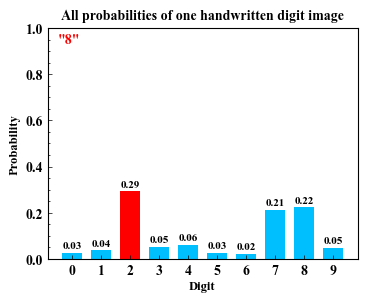

预测标签结果:[2]


------------------------------------------------------------------------


测试集的总体情况:
acc_score:0.87125
pre_score:0.8733729521214348
rec_score:0.867709270263451


测试集的混淆矩阵:


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23344\2016190954.py:129: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), weight='bold')


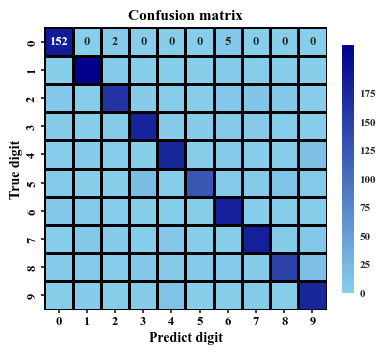



测试集的第1张手写数字图片:


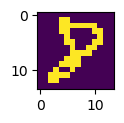

Label:8
Prediction:2



In [10]:
## 在MNIST数据集上测试 ##

# 利用实例，进行测试
test_size = X_MNIST_te.shape[0]
y_MNIST_predict = example.predict(X_test = X_MNIST_te[:test_size])

# 展示测试集的测试结果:

# 创建指标类实例
metric = metrics(y_MNIST_te[:test_size],y_MNIST_predict)
image_index = 0

# 可视化特定手写图片对各数字的预测概率
print("读取图像的各数字预测概率:")
metric.show_one_image_predict(image_index, save_mnist_dir)
print("预测标签结果:[",np.argmax(y_MNIST_predict[image_index]),']',sep="")
plt.rcdefaults()
print('\n')

print("------------------------------------------------------------------------")
print('\n')

# 测试集的整体结果:
print("测试集的总体情况:")
# 输出准确率、精确率和召回率
print("acc_score:"+str(metric.acc_score))
print("pre_score:"+str(metric.pre_score))
print("rec_score:"+str(metric.rec_score))
print('\n')

# 可视化混淆矩阵
print("测试集的混淆矩阵:")
metric.show_confusion_matrix(save_mnist_dir)
plt.rcdefaults()
print('\n')

# 展示部分图片的预测结果
for i in range(image_index,image_index+20,1):
    if y_MNIST_te[i][0] != np.argmax(y_MNIST_predict[i]):
        print("测试集的第",i+1,"张手写数字图片:",sep="")
        # 原始图片需要顺时针旋转90度再水平翻转才是正确结果
        img_show=np.flip(np.rot90(X_MNIST_te[i],k=-1),1)
        #展示图片，不要太大
        plt.figure(figsize=(1,1))
        plt.imshow(img_show)
        # plt.imshow(img_show,cmap='gray')
        plt.show()
        print("Label:",y_MNIST_te[i][0],sep="")
        print("Prediction:",np.argmax(y_MNIST_predict[i]),'',sep="")
        plt.rcdefaults()
        print()

读取图像的各数字预测概率:


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23344\2016190954.py:152: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), color = 'black', weight = 'bold')


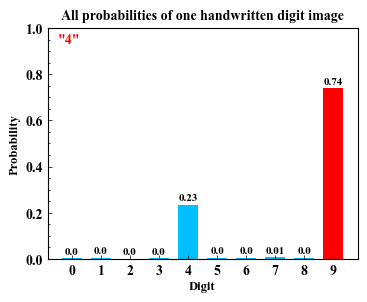

预测标签结果:[9]


------------------------------------------------------------------------


测试集的总体情况:
acc_score:0.975
pre_score:0.9800000000000001
rec_score:0.975


测试集的混淆矩阵:


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23344\2016190954.py:129: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), weight='bold')


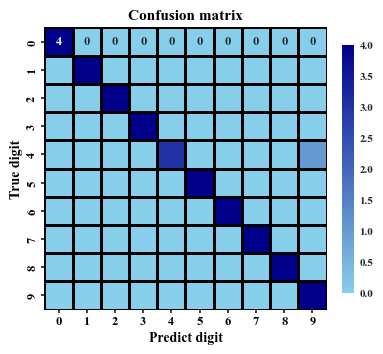



测试集的第5张手写数字图片:


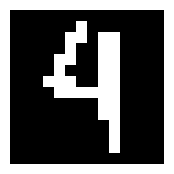

Label:4
Prediction:9



In [11]:
## 在自定义数据集上测试 ##

# 加载数据集
X_resized_Custom_image,y_Custom_image = get_Custom_resized_image(re_size, False)
# 利用实例，进行测试
y_Custom_image_predict = example.predict(X_test = X_resized_Custom_image)

# 展示测试集的测试结果:

# 创建指标类实例
metric = metrics(y_Custom_image, y_Custom_image_predict)

# 可视化特定手写图片对各数字的预测概率
print("读取图像的各数字预测概率:")
metric.show_one_image_predict(4, save_custom_dir)
print("预测标签结果:[",np.argmax(y_Custom_image_predict[4]),']',sep="")
plt.rcdefaults()
print('\n')
print("------------------------------------------------------------------------")
print('\n')

# 测试集的整体结果:
print("测试集的总体情况:")
# 输出准确率、精确率和召回率
print("acc_score:"+str(metric.acc_score))
print("pre_score:"+str(metric.pre_score))
print("rec_score:"+str(metric.rec_score))
print('\n')

# 可视化混淆矩阵
print("测试集的混淆矩阵:")
metric.show_confusion_matrix(save_custom_dir)
plt.rcdefaults()
print('\n')

# 展示部分图片的预测结果
for i in range(40):
    if np.argmax(y_Custom_image_predict[i]) != y_Custom_image[i][0]:
        print("测试集的第",i+1,"张手写数字图片:",sep="")
        # 原始图片需要顺时针旋转90度再水平翻转才是正确结果
        img_show=np.flip(np.rot90(X_resized_Custom_image[i],k=-1),1)
        #展示图片，不要太大
        plt.figure(figsize=(2,2))
        # plt.imshow(img_show)
        plt.imshow(img_show,cmap='gray')
        plt.axis('off')
        plt.savefig(save_custom_dir+"error_image.jpg", bbox_inches = 'tight', pad_inches = 0.0, dpi=400)
        
        plt.show()
        print("Label:",y_Custom_image[i][0],sep="")
        print("Prediction:",np.argmax(y_Custom_image_predict[i]),'',sep="")
        plt.rcdefaults()
        print()